In [1]:
import numpy as np
from fastai.tabular.all import *


import pandas as pd

from distvis import plots as dplot

In [2]:
def get_predictions(df, learn):
    df_dls = learn.dls.valid_ds.new(df)
    df_dls.process()
    df_dls.conts = df_dls.conts.astype(np.float32)
    dl = learn.dls.valid.new(df_dls)
    #################################################################################
    pred, actual = learn.get_preds(dl=dl, with_input=False, with_decoded=False)
    results = pd.DataFrame(columns=['prediction'], index=range(len(pred)))
    results.loc[:, ['prediction']] = pred.numpy()
    return results

In [3]:
datos = pd.read_csv('../datos/datos_procesados.csv').iloc[:, 1:]

In [4]:
numerical_features = [
    'edad', 'meses_empleo'
]

categorical_features = [
    'sexo', 'rol_hogar', 'tipo_zona', 
    'termino_nivel', 'cine', 'est_conyugal', 'region', 'comuna', 'provincia',
    'est_subcontratado', 'categoria_empleo', 'grupo_ocupacion', 'nacionalidad'
]

features = categorical_features + numerical_features
target = "sueldo_neto"


mean = np.log(datos[target]).mean()
std = np.log(datos[target]).std()

def transform(x):
    return (np.log(x) - mean)/std

def inv_transf(x):
    return np.exp(std*x + mean)

datos[target+'_transf'] = transform(datos[target])
datos[target+'_transf'].min(), datos[target+'_transf'].max()

(-6.070495704763379, 4.680141356571926)

In [5]:
test_index = datos.sample(frac=.1, random_state=1313).index
datos['is_test'] = 0 
datos.loc[test_index, 'is_test'] = 1

In [6]:
valid_idx = list(datos[datos.is_test == 1].index)
train_idx = list(datos[datos.is_test == 0].index)

splits = (list(train_idx),list(valid_idx))
print(len(train_idx), len(valid_idx))

26258 2918


In [7]:
procs = [FillMissing, Normalize, Categorify]

In [8]:
tabular_df_res = TabularPandas(datos, procs, categorical_features, 
                               numerical_features, 
                               y_names=target+'_transf',
                               splits=splits)
dls = tabular_df_res.dataloaders(bs=1024)

In [9]:
layer_0, layer_1 = 100, 50
learn = tabular_learner(dls, layers=[layer_0, layer_1], n_out=1, y_range=(-7, 5),
                        loss_func=F.mse_loss, cbs=[ShowGraphCallback], metrics=[mae])
learn.summary()

TabularModel (Input shape: 1024 x torch.Size([1024, 2]))
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 3            
Embedding                                 9          True      
____________________________________________________________________________
                     1024 x 6            
Embedding                                 72         True      
____________________________________________________________________________
                     1024 x 3            
Embedding                                 12         True      
Embedding                                 9          True      
____________________________________________________________________________
                     1024 x 6            
Embedding                                 66         True      
____________________________________________________________________________
                     1024 x 5            
Embedding                                

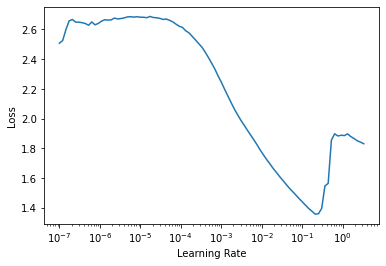

In [10]:
lr = learn.lr_find()[0]

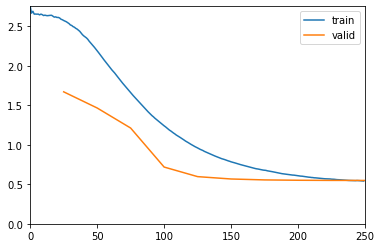

In [11]:
lr = 1e-4
learn.fit_one_cycle(10, lr)

In [12]:
datos['sueldo_predicho'] = inv_transf(get_predictions(datos, learn))
datos['error'] = datos.eval('sueldo_predicho - sueldo_neto')
datos['error_porcentual'] = datos.eval('error/sueldo_neto')
datos['error_porcentual_abs'] = datos.eval('abs(error_porcentual)')

In [13]:
datos['error_porcentual_abs'].mean()

0.47387996993948783

In [14]:
datos['error_porcentual_abs'].median()

0.276943658481354

<AxesSubplot:>

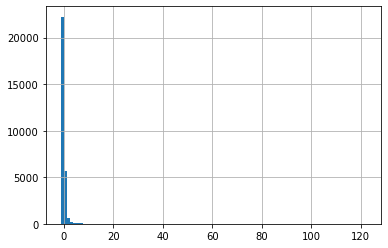

In [15]:
datos['error_porcentual'].hist(bins=100)

<AxesSubplot:>

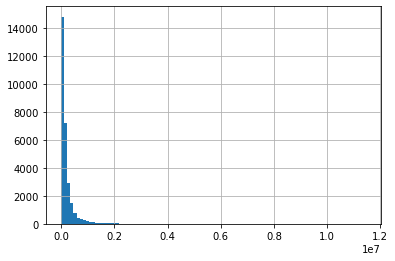

In [16]:
abs(datos['error']).hist(bins=100)

<AxesSubplot:>

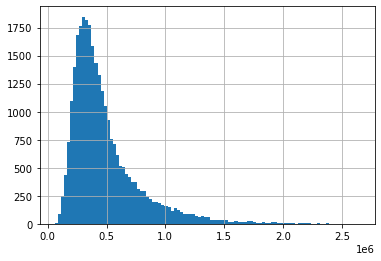

In [17]:
datos['sueldo_predicho'].hist(bins=100)

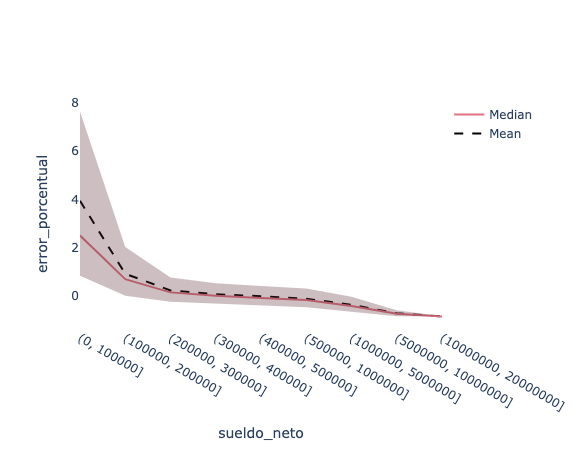

In [18]:
bins = [0, 100_000, 200_000, 300_000, 400_000, 500_000, 1_000_000, 5_000_000, 10_000_000, 20_000_000]
dplot.marginal_dependency_plot(datos, 'error_porcentual', target, bins=bins)

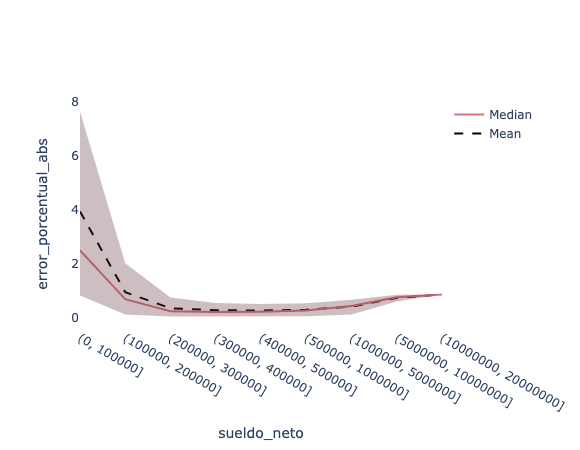

In [19]:
dplot.marginal_dependency_plot(datos, 'error_porcentual_abs', target, bins=bins)

# Análisis contrafactual de fairness

- Feature sensible $s$ y el resto de features $x$. Ejemplo: $s=$ sexo 
- El feature $s$ está particionado en un conjunto de personas desprotegidas $D$ y otro conjunto de personas privilegiadas $P$. Ejemplo: para $s=$ sexo, $D=$ {Mujer} y $P=$ {Hombre}
- Para un modelo predictivo $F$ y una persona con features no sensibles $x$ definimos para $s_d \in D$  y $s_p \in P$ la métrica de fairness que mide cuanto más porcentualmente ganaría la persona $(x, s_p)$ por sobre $(x, s_d)$, es decir:
$$\phi(x, s_p, s_d) = \frac{F(x, s_p)-F(x, s_d)}{F(x, s_d)}$$
- Luego para cada persona en los datos $z_i = (x_i, s_i)$ promediamos todos las posibles comparaciones contrafactuales definidas en el punto anterior, es decir:
$$\frac{1}{|D||P|}\sum_{s_p \in P, s_d \in P}\phi(x, s_p, s_d)$$


In [20]:
dict_particion = {
    'sexo': {
        'desprotegido': ['Mujer'],
        'privilegiado': ['Hombre'],
    }
    ,
    
    'region': {
        'desprotegido':  [v for v in datos['region'].unique() if v != "Metropolitana de Santiago"],
        'privilegiado':  ["Metropolitana de Santiago"],
    }   
}

dict_sample_frac = {
    'sexo': 1, 'region': .05
}

In [21]:
from itertools import product

In [22]:
def diferencia_porcentual(df, feature):
    desprotegidos = dict_particion[feature]['desprotegido']
    privilegiados = dict_particion[feature]['privilegiado']
    combinaciones = [list(par) for par in product(desprotegidos, privilegiados)]
    sueldos = df.set_index(feature)[['sueldo_predicho']]
    valores = np.array([sueldos.loc[comb, 'sueldo_predicho'].values for comb in combinaciones])
    return ((valores[:, 1] - valores[:, 0])/valores[:, 0]).mean(axis=0) #sueldos[combinaciones[0]]


In [23]:
diff_pct_dict = {}


for feature, particion in dict_particion.items():
    print(feature)

    valores = particion['privilegiado'] + particion['desprotegido']
    otros_features = [f for f in features if f != feature]
    datos_contraf = datos[otros_features].sample(frac=dict_sample_frac[feature], random_state=1313).copy()
    datos_contraf['dummy'] = 1
    datos_contraf['id_persona'] = datos_contraf.index
    valores_df = pd.DataFrame({feature: valores, 'dummy': 1})
    datos_contraf = pd.merge(datos_contraf, valores_df, on='dummy')
    datos_contraf['sueldo_predicho'] = inv_transf(get_predictions(datos_contraf, learn))
    diff_pct = datos_contraf.groupby('id_persona').apply(diferencia_porcentual, feature=feature)
    diff_pct_dict[feature] = diff_pct
    datos = pd.merge(datos, diff_pct.to_frame(f'diff_pct_{feature}'), 
                     left_index=True, right_index=True,
                     how='left')
    del datos_contraf

sexo


region


0.2429094843793777


<AxesSubplot:>

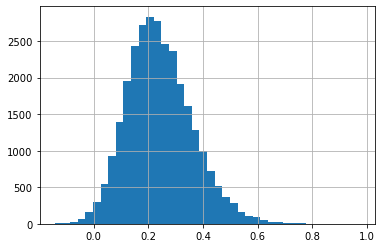

In [24]:
var = 'sexo'
print(diff_pct_dict[var].mean())
diff_pct_dict[var].hist(bins=40)

0.19236235561513923


<AxesSubplot:>

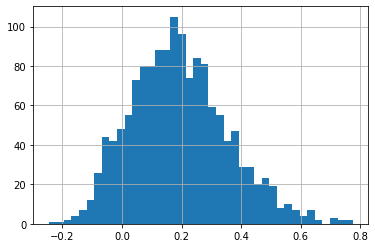

In [25]:
var = 'region'
print(diff_pct_dict[var].mean())
diff_pct_dict[var].hist(bins=40)

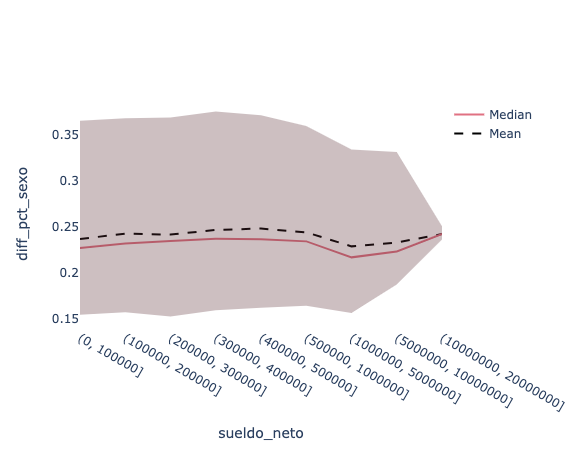

In [26]:
dplot.marginal_dependency_plot(datos, 'diff_pct_sexo', target, bins=bins, lower_q=0.25, upper_q=0.85)

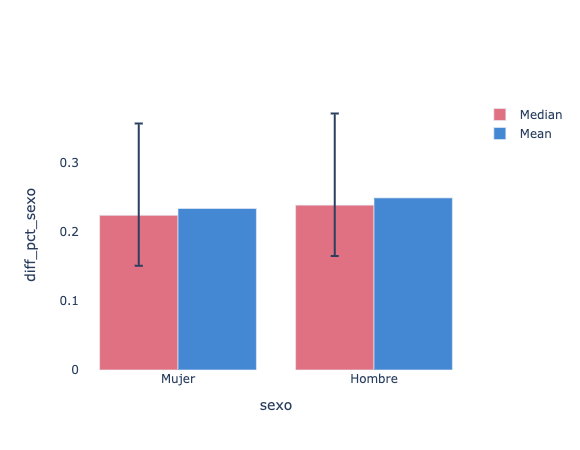

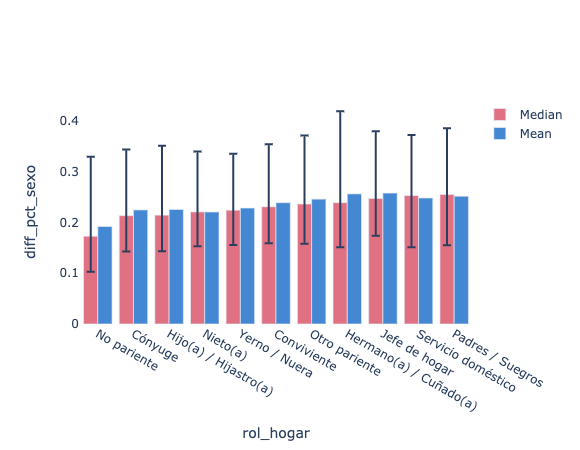

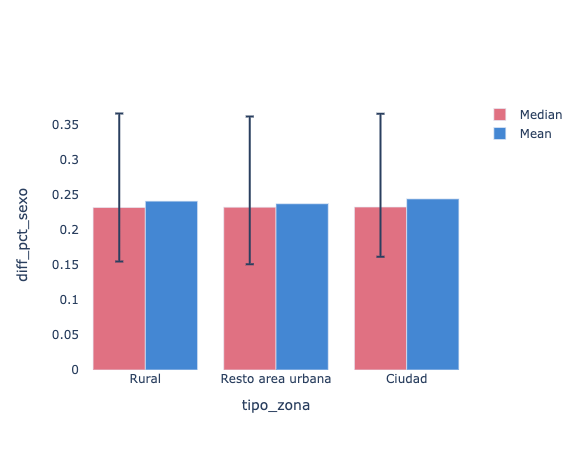

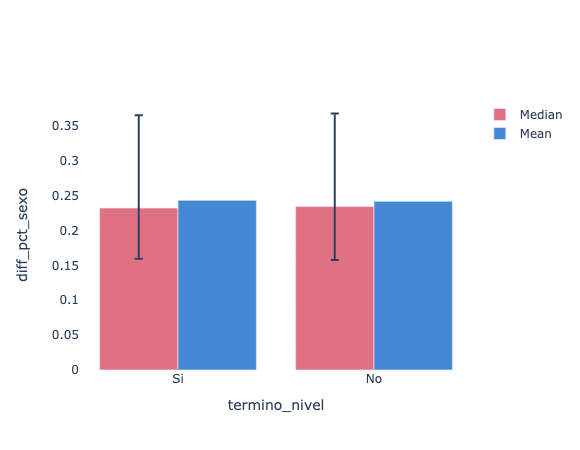

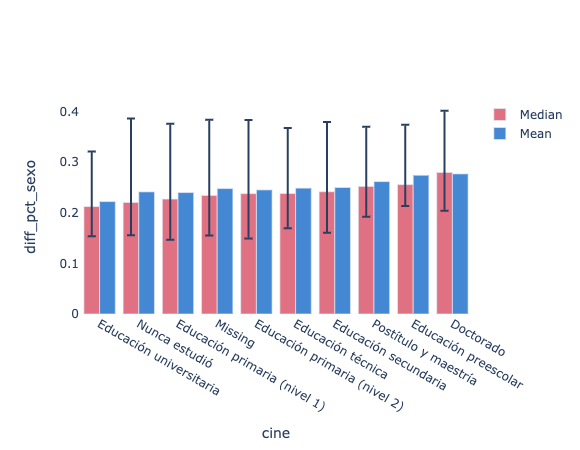

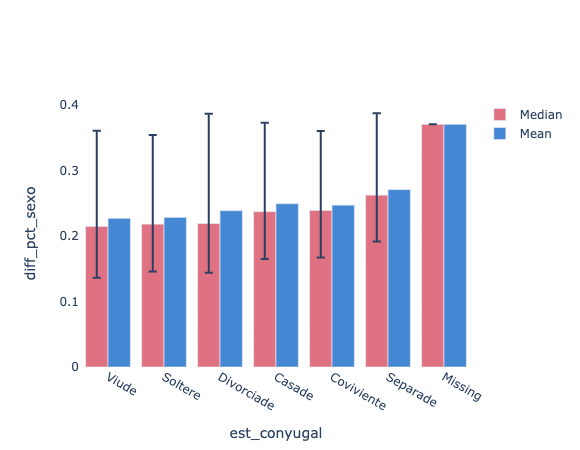

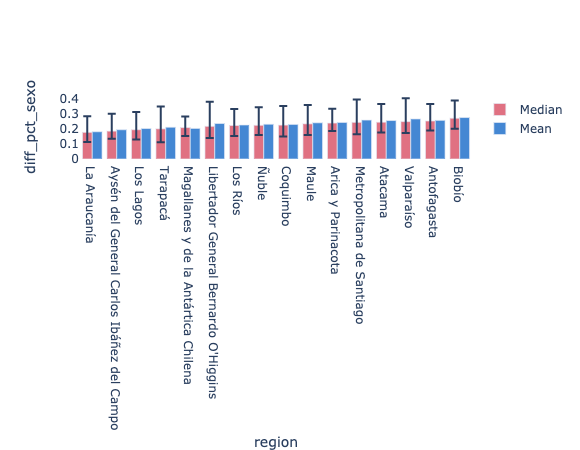

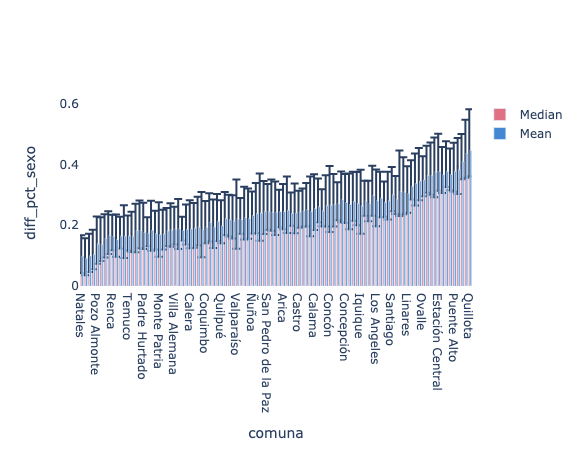

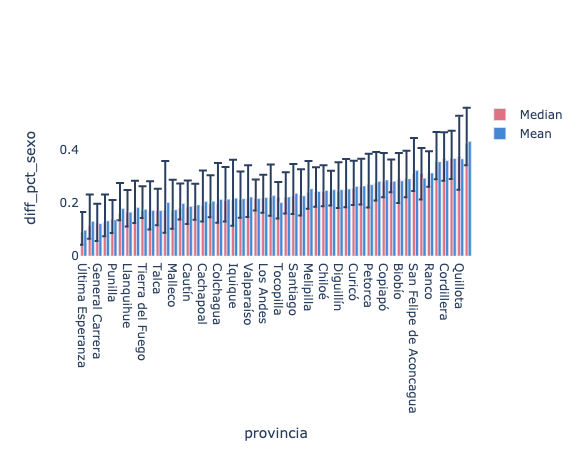

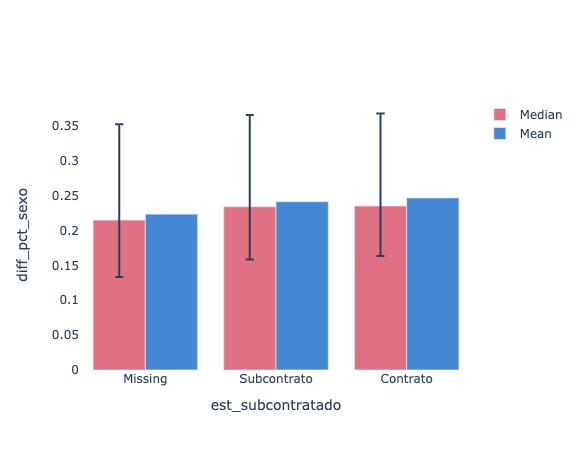

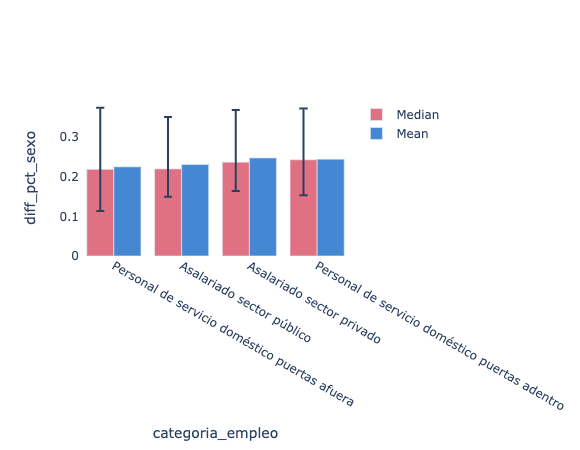

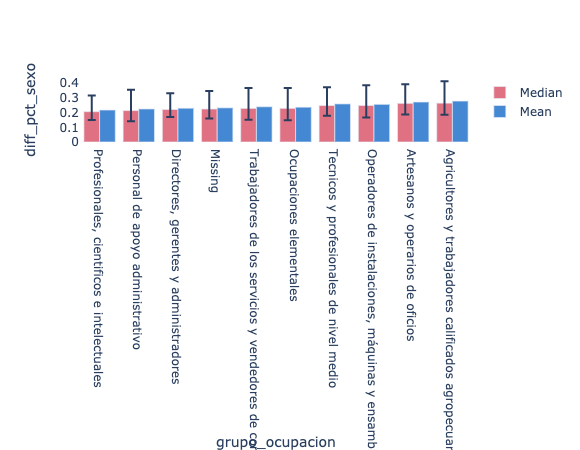

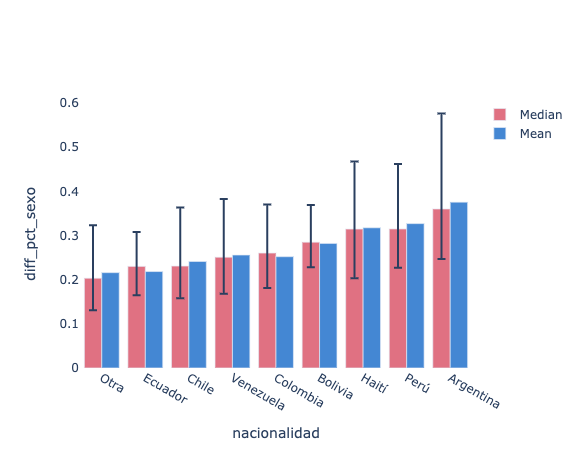

In [27]:
for f in categorical_features:
    fig = dplot.marginal_dependency_plot(datos, 'diff_pct_sexo', f, categorical_feature=True, lower_q=0.25, upper_q=0.85)
    fig.show()

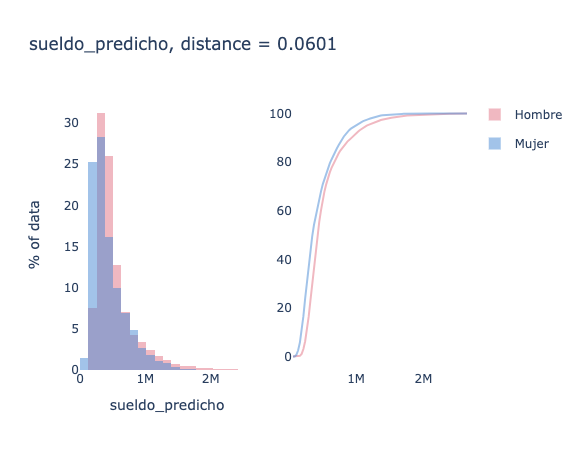

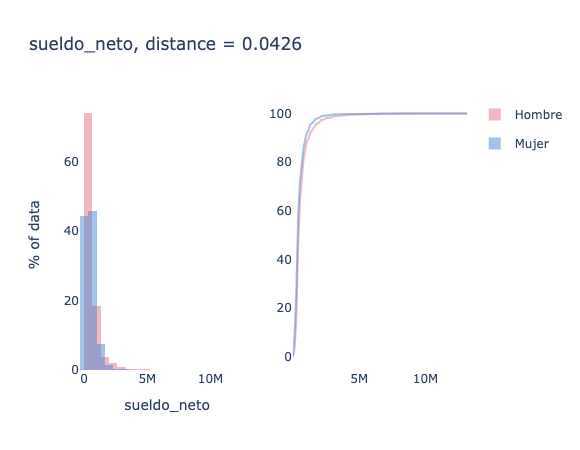

distance
feature                  
sueldo_predicho  0.060097
sueldo_neto      0.042558

In [28]:
dplot.compare_numerical_features(datos, ['sueldo_neto', 'sueldo_predicho'], groupby='sexo', nbins=20)